# Imports

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
# Maybe use https://gitlab.com/mike01/pypacker or https://stackoverflow.com/questions/30826123/python-scapy-vs-dpkt
import scapy
import pickle
import subprocess
from subprocess import PIPE
from pathlib import Path
from datetime import datetime, timedelta
from scapy.all import *
import networkx as nx
import matplotlib.dates as mdates
import statistics
import sharedVariables
from sharedVariables import *

In [58]:
# Datasets
dataset_sources = {
    'advanced': 'data/data-advanced-mongo-with-latency-3/20210922-17-experiment-advanced-mongo-with-latency-3',
    'baseline': 'data/data-baseline-with-latency-3/20210922-17-experiment-baseline-with-latency-3',
    'syncmesh': 'data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3'
}
print(ci)
ci = "true"
if ci == "true": 
    dataset_sources = {}
    print("Running CI Data detection")
    for folder in os.listdir("data"):
        if folder.startswith("data"):
            dataset_sources[folder[5:folder.find("with")-1]] = "data/" + folder + "/" + os.listdir("data/" + folder)[0]


true
Running CI Data detection


In [3]:
# Utility Functions
def to_human_readable(size, unit=True):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    if unit:
        return "{0:.2f} {1}".format(size, mem[n])
    else:
        return "{0:.2f}".format(size)

In [4]:
ip_seperator

'92.60.39.199'

In [44]:
def filterDataForSeperator(df): 
    df = df[df["ip.src"].isin([ip_seperator, ip_client])]
    df = df[df["ip.dst"].isin([ip_seperator, ip_client])]
    df = df[(df["tcp.dstport"] == 443)] #  | (df["tcp.srcport"] == 443)
    return df

def filterDataForLocalTraffic(df): 
    df = df[df["ip.src"].str.contains(r'^10\.')]
    df = df[df["ip.dst"].str.contains(r'^10\.')]
    df = df[(df["tcp.dstport"] != 22) & (df["tcp.srcport"] != 22)]
    return df

def loadDataSet(folder):
    df_base = None
    for filename in os.listdir(folder):
        if filename.endswith(".csv") and filename.startswith("10"):
            csvfile = os.path.join(Path.cwd(), folder, filename)
            print(csvfile)
            EPOCH = datetime(1900, 1, 1)
            currentdf = pd.read_csv(csvfile)
            # print(len(currentdf))

            currentdf["frame.time_epoch"] = currentdf["frame.time_epoch"].apply(lambda x: datetime.utcfromtimestamp(float(x)))

            currentdf.set_index('frame.time_epoch', inplace=True)

            currentdf.dropna(inplace=True,subset=['ip.src', 'ip.dst'])
            # currentdf.to_csv(filename + ".csv")

            if (df_base is None):
                df_base = currentdf
            else:
                df_base = df_base.append(currentdf)

        else:
            continue

    seperatordf = filterDataForSeperator(df_base)
    timings = seperatordf.index.values
    # df_base.sort_index().to_csv("test.csv")
    # print(df_base)
    df_base = filterDataForLocalTraffic(df_base)
    return (df_base.sort_index(), timings)

datasets = {}
for source in dataset_sources:
    datasets[source] = loadDataSet(dataset_sources[source])
    
# test = loadDataSet("data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3")
datasets["advanced"][1]

                            tcp.analysis.initial_rtt       ip.id  \
frame.time_epoch                                                   
2021-09-22 16:24:20.041349                       NaN  0x0000c3fc   
2021-09-22 16:24:20.041441                       NaN  0x0000c3fd   
2021-09-22 16:24:20.153501                       NaN  0x00000000   
2021-09-22 16:24:20.154659                       NaN  0x00000000   
2021-09-22 16:24:20.155023                       NaN  0x000020c0   
...                                              ...         ...   
2021-09-22 16:56:06.493907                  0.029389  0x000015a6   
2021-09-22 16:56:06.522117                  0.029389  0x000015a7   
2021-09-22 16:56:06.550465                  0.029389  0x000015a8   
2021-09-22 16:56:06.597716                  0.029389  0x000015a9   
2021-09-22 16:56:06.633999                  0.029389  0x000015aa   

                                     ip.src           ip.dst  ip.len  \
frame.time_epoch                           

In [42]:
df = datasets["syncmesh"][0]
# df[(df['ip.src']=='10.1.0.11') & (df['ip.dst']=='10.2.0.12')]
# df[(df['ip.src']=='10.1.0.11')]
df

KeyError: 'syncmesh'

In [29]:
def calcSubset(df):
    nodes = list(dict.fromkeys(df["ip.src"].unique().tolist() + df["ip.dst"].unique().tolist()))
    # print(nodes)
    betweenNodesDataset = {}
    nodeCombinations = list(itertools.combinations(nodes, r=2))
    for combination in nodeCombinations: 
        # print(combination)
        # print(df[df['ip.src']==combination[0] & df['ip.dst']==combination[1]])
        # Use both src_ip and dest_ip as they are not request related
        key = "between " + combination[0] + " and " + combination[1]
        betweenNodesDataset[key] = df[((df['ip.src']==str(combination[0])) & (df['ip.dst']==str(combination[1]))) | ((df['ip.src']==str(combination[1])) & (df['ip.dst']==str(combination[0])))]

    return betweenNodesDataset

node_datasets = {}
for key in datasets:
    node_datasets[key] = calcSubset(datasets[key][0])

setname = "syncmesh"
for key in node_datasets[setname]:
    print(key, ":", len(node_datasets[setname][key]))
    # print(node_datasets[setname][key])
    

['10.0.0.2', '10.0.0.3', '10.0.0.4', '10.3.0.13', '10.1.0.11', '10.2.0.12']
['10.0.0.2', '10.0.0.3', '10.3.0.13', '10.2.0.12', '10.1.0.11']
['10.0.0.2', '10.1.0.11', '10.3.0.13', '10.2.0.12']
between 10.0.0.2 and 10.1.0.11 : 19013
between 10.0.0.2 and 10.3.0.13 : 0
between 10.0.0.2 and 10.2.0.12 : 0
between 10.1.0.11 and 10.3.0.13 : 15978
between 10.1.0.11 and 10.2.0.12 : 16736
between 10.3.0.13 and 10.2.0.12 : 0


In [31]:
# Experiments
def splitExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])
    return return_data

node_experiment_datasets = {}
for key in datasets:
    print(key)
    print(datasets[key][1])
    node_experiment_datasets[key] = splitExperiments(datasets[key][0], datasets[key][1])

setname = "syncmesh"
for key in node_experiment_datasets[setname]:
    print(key, ":", len(node_experiment_datasets[setname][key]))


advanced
18863
['10.0.0.2', '10.0.0.3', '10.0.0.4', '10.3.0.13', '10.1.0.11', '10.2.0.12']
29131
['10.0.0.2', '10.0.0.3', '10.1.0.11', '10.2.0.12', '10.3.0.13', '10.0.0.4']


/tmp/ipykernel_5684/3364624665.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  print(len(df.loc[str(timings[index]):str(timings[index + 1])]))
/tmp/ipykernel_5684/3364624665.py:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])


37067
['10.0.0.2', '10.0.0.3', '10.3.0.13', '10.0.0.4', '10.2.0.12', '10.1.0.11']
54460
['10.0.0.2', '10.0.0.3', '10.2.0.12', '10.3.0.13', '10.0.0.4', '10.1.0.11']
16490
['10.0.0.2', '10.0.0.3', '10.0.0.4', '10.3.0.13', '10.1.0.11', '10.2.0.12']
16577
['10.0.0.2', '10.0.0.3', '10.2.0.12', '10.3.0.13', '10.0.0.4', '10.1.0.11']
16617
['10.0.0.2', '10.0.0.3', '10.0.0.4', '10.3.0.13', '10.1.0.11', '10.2.0.12']
16772
['10.0.0.2', '10.0.0.3', '10.0.0.4', '10.3.0.13', '10.1.0.11', '10.2.0.12']
baseline
2752
['10.0.0.2', '10.0.0.3', '10.3.0.13', '10.2.0.12', '10.1.0.11']
5150
['10.0.0.2', '10.0.0.3', '10.3.0.13', '10.2.0.12', '10.1.0.11']
6629
['10.0.0.2', '10.0.0.3', '10.3.0.13', '10.2.0.12', '10.1.0.11']
9873
['10.0.0.2', '10.0.0.3', '10.3.0.13', '10.2.0.12', '10.1.0.11']
2502
['10.0.0.2', '10.0.0.3', '10.3.0.13', '10.2.0.12', '10.1.0.11']
4307
['10.0.0.2', '10.0.0.3', '10.3.0.13', '10.2.0.12', '10.1.0.11']
5441
['10.0.0.2', '10.0.0.3', '10.3.0.13', '10.2.0.12', '10.1.0.11']
8005
['10.0.0.2'

10.0.0.2 10.0.0.3
Client Server
10.0.0.4 10.0.0.3
Server
Config Server
10.0.0.3 10.3.0.13
Server Node 3
10.0.0.3 10.1.0.11
Server Node 1
10.0.0.3 10.2.0.12
Server Node 2
10.0.0.4 10.3.0.13
Server
Config Node 3
10.1.0.11 10.0.0.4
Node 1 Server
Config
10.0.0.4 10.2.0.12
Server
Config Node 2
10.3.0.13 10.1.0.11
Node 3 Node 1
10.3.0.13 10.2.0.12
Node 3 Node 2
10.2.0.12 10.1.0.11
Node 2 Node 1


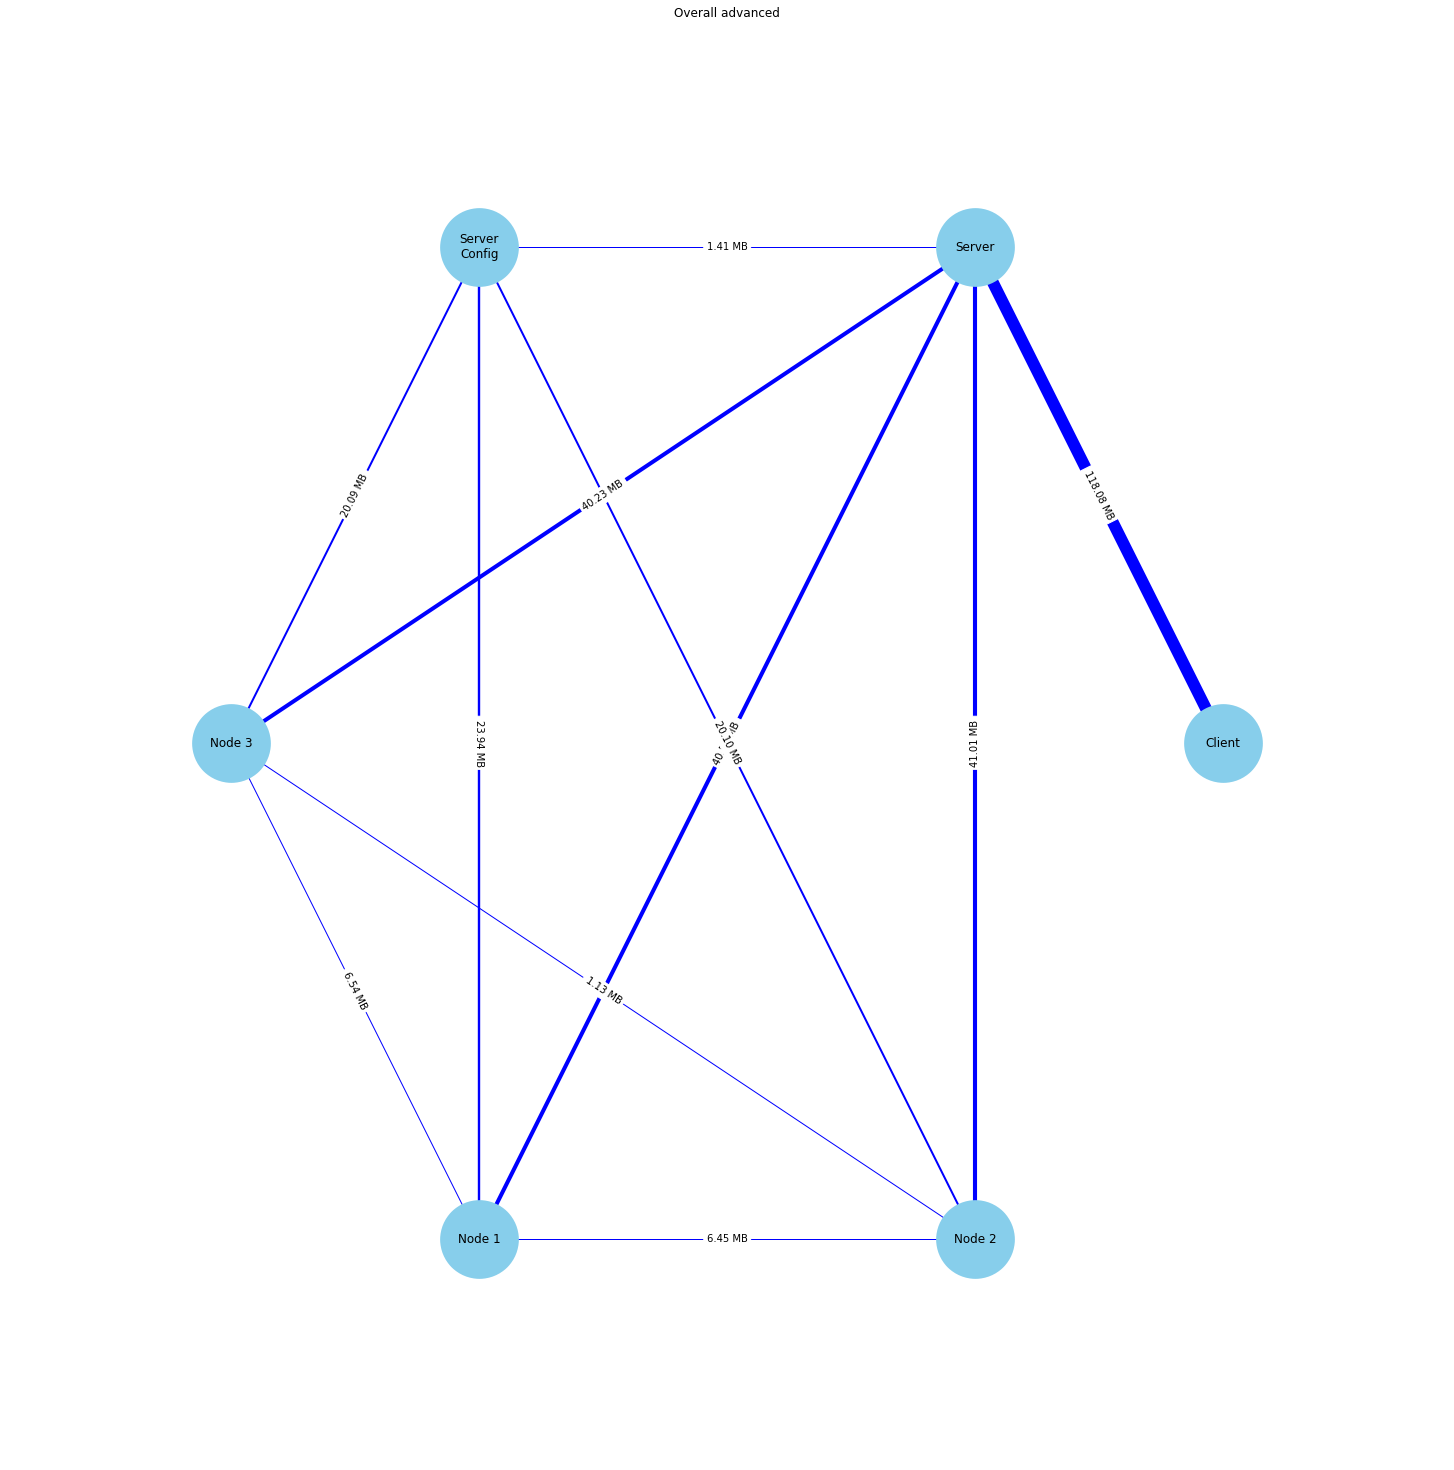

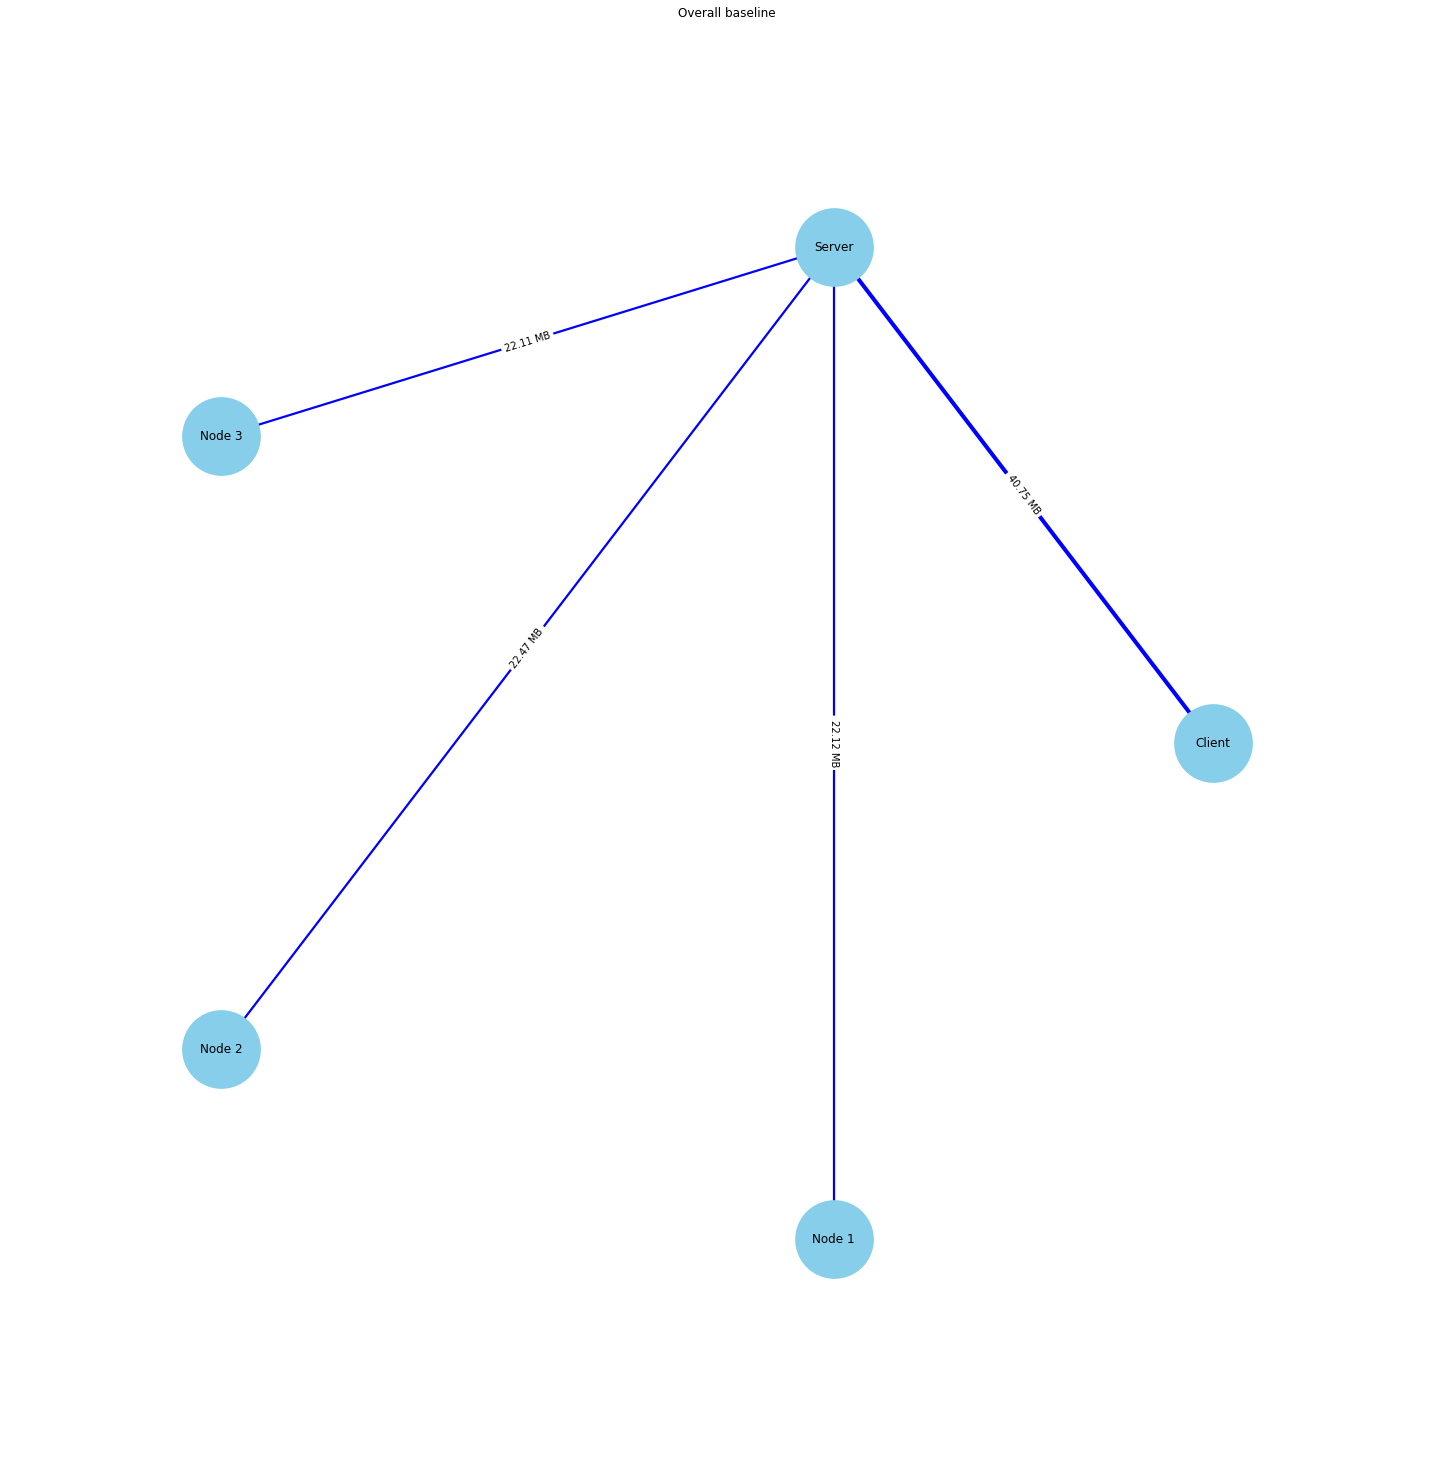

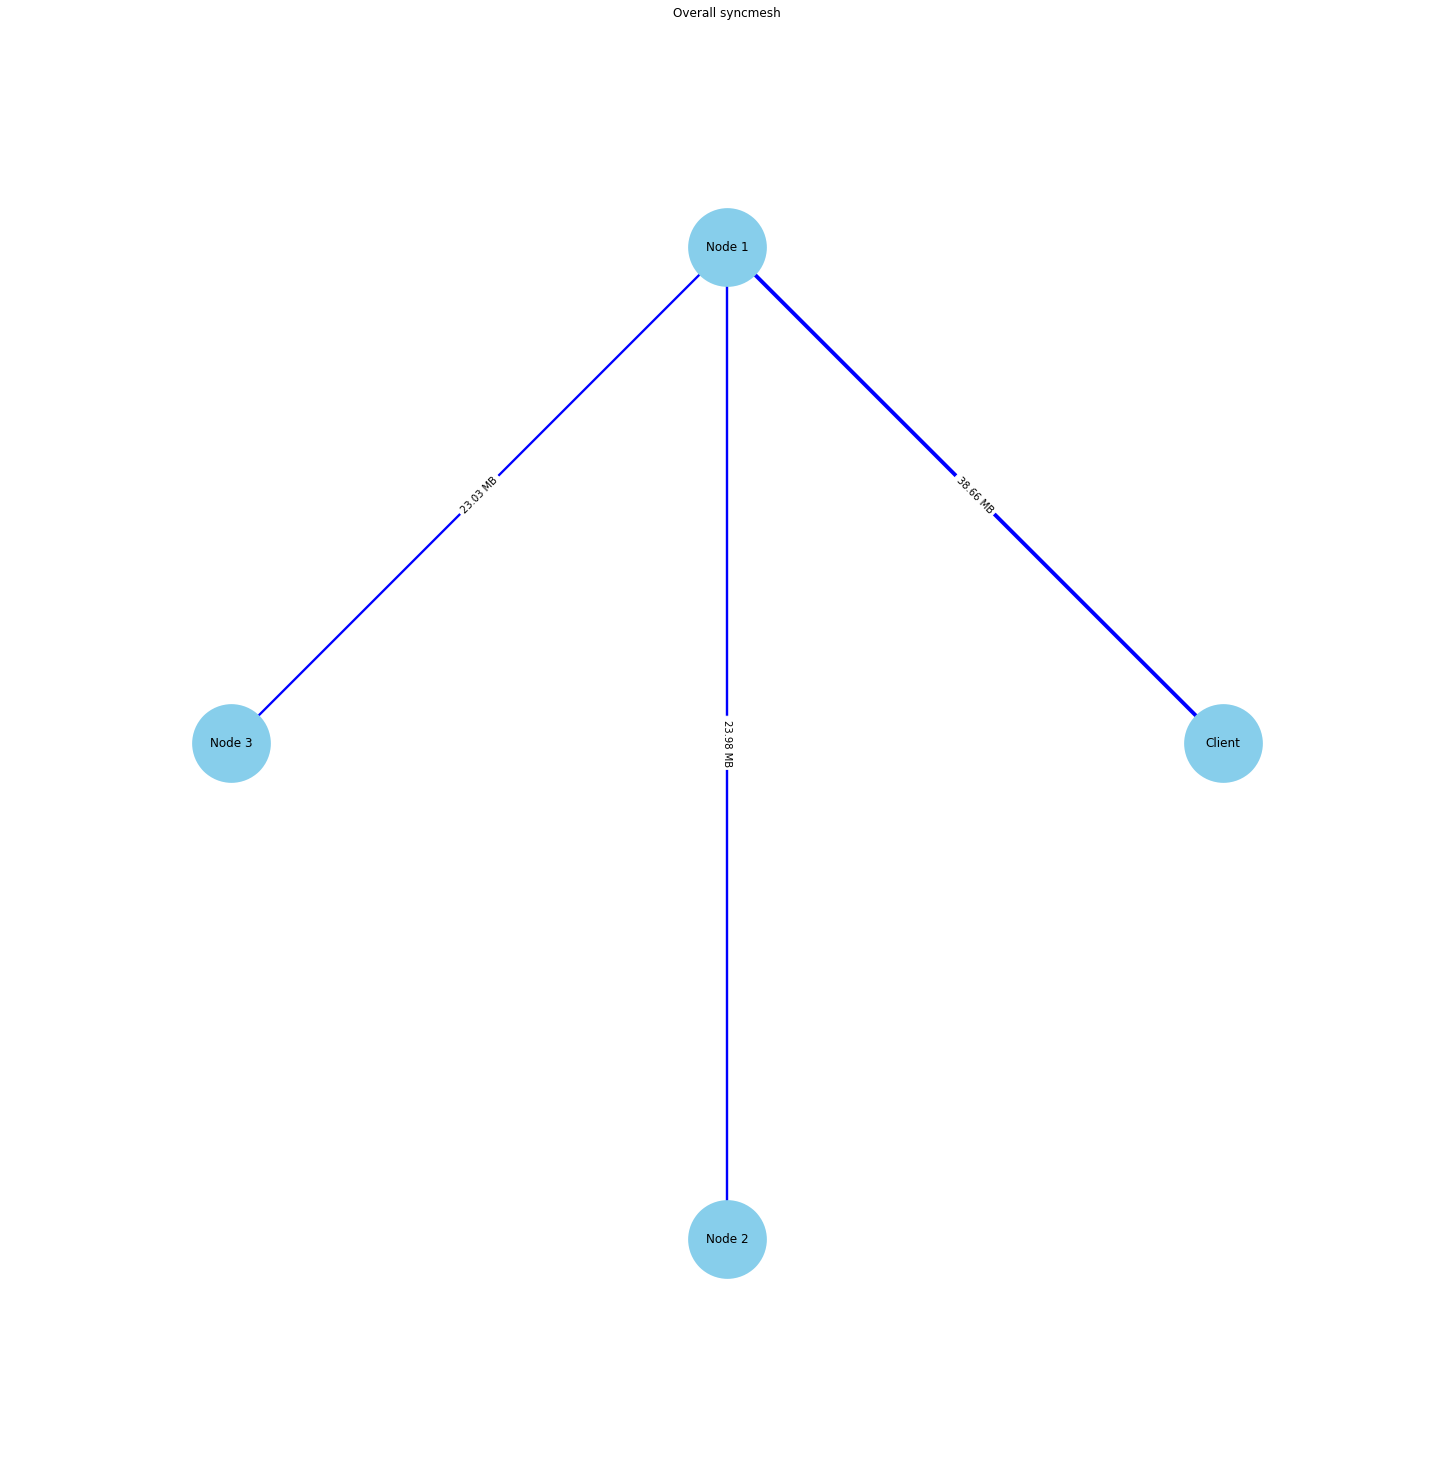

In [9]:
def get_node_name(ip):
    if(ip == "10.0.0.2"):
        return "Client"
    elif(ip == "10.0.0.3"):
        return "Server"
    elif(ip == "10.0.0.4"):
        return "Server\nConfig"
    elif(ip == "10.0.0.255"):
        return "ORCHESTRATOR"
    elif(ip.startswith("10.")):
        return "Node " + ip.split(".")[1]
    return ip

for index, subset_key in enumerate(node_datasets):
    G = nx.Graph()
    # print(subset_key)
    for node_dataset_key in node_datasets[subset_key]: 
        subset = node_datasets[subset_key][node_dataset_key]
        if len(subset["ip.dst"]) > 0:

            if subset_key == "advanced":
                # print(node_dataset_key) 
                print(subset["ip.src"].iloc[0], subset["ip.dst"].iloc[0]) 
                print(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]))
            G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='b', weight=np.clip(subset["ip.len"].sum()/10000000, 1, 1000), label=to_human_readable(subset["ip.len"].sum()))

    pos = nx.circular_layout(G)

    size =20
    plt.figure(index+1,figsize=(size,size))
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
    nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="skyblue", node_shape="o", alpha=1, linewidths=40)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

    plt.axis('off')
    axis = plt.gca()
    axis.set_title("Overall " + subset_key)
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.savefig("out/network_"+subset_key+".png")
    

plt.show()

In [10]:
# node_experiment_datasets["syncmesh"]["aggregate30"]['between 10.2.0.12 and 10.1.0.11'].to_csv("test.csv")
# node_experiment_datasets["baseline"]["aggregate30"]['between 10.1.0.3 and 10.1.0.2'].to_csv("test2.csv")

collect1
between 10.0.0.2 and 10.0.0.3
between 10.0.0.3 and 10.0.0.4
between 10.0.0.3 and 10.3.0.13
between 10.0.0.3 and 10.1.0.11
between 10.0.0.3 and 10.2.0.12
between 10.0.0.4 and 10.3.0.13
between 10.0.0.4 and 10.1.0.11
between 10.0.0.4 and 10.2.0.12
between 10.3.0.13 and 10.1.0.11
between 10.3.0.13 and 10.2.0.12
between 10.1.0.11 and 10.2.0.12
collect7
between 10.0.0.2 and 10.0.0.3
between 10.0.0.3 and 10.1.0.11
between 10.0.0.3 and 10.2.0.12
between 10.0.0.3 and 10.3.0.13
between 10.0.0.3 and 10.0.0.4
between 10.1.0.11 and 10.2.0.12
between 10.1.0.11 and 10.3.0.13
between 10.1.0.11 and 10.0.0.4
between 10.2.0.12 and 10.3.0.13
between 10.2.0.12 and 10.0.0.4
between 10.3.0.13 and 10.0.0.4
collect14
between 10.0.0.2 and 10.0.0.3
between 10.0.0.3 and 10.3.0.13
between 10.0.0.3 and 10.0.0.4
between 10.0.0.3 and 10.2.0.12
between 10.0.0.3 and 10.1.0.11
between 10.3.0.13 and 10.0.0.4
between 10.3.0.13 and 10.2.0.12
between 10.3.0.13 and 10.1.0.11
between 10.0.0.4 and 10.2.0.12
between 1

/tmp/ipykernel_5684/1301179033.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(int(str(index)+str(e_index)))


aggregate7
between 10.0.0.2 and 10.1.0.11
between 10.1.0.11 and 10.3.0.13
between 10.1.0.11 and 10.2.0.12
aggregate14
between 10.0.0.2 and 10.1.0.11
between 10.1.0.11 and 10.3.0.13
between 10.1.0.11 and 10.2.0.12
aggregate30
between 10.0.0.2 and 10.1.0.11
between 10.1.0.11 and 10.3.0.13
between 10.1.0.11 and 10.2.0.12


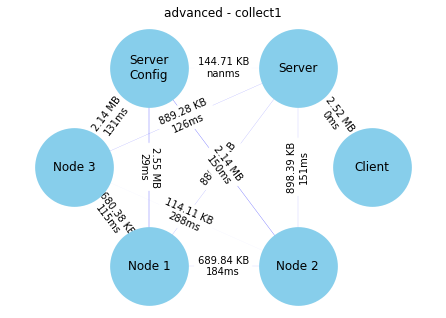

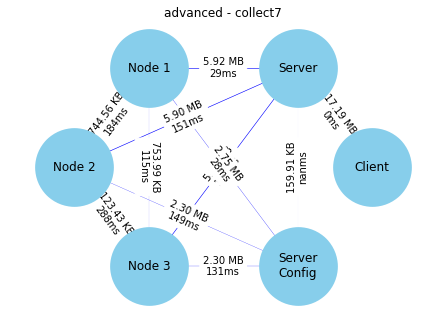

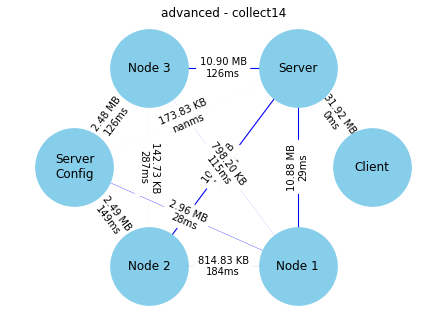

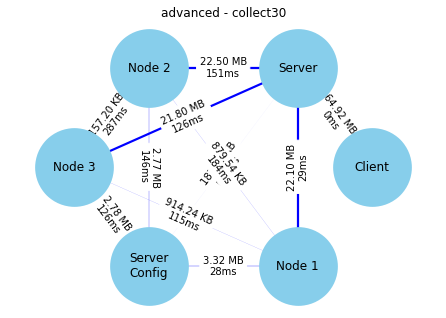

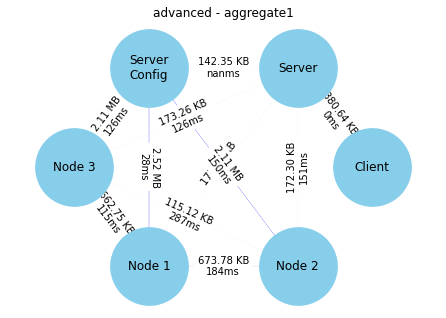

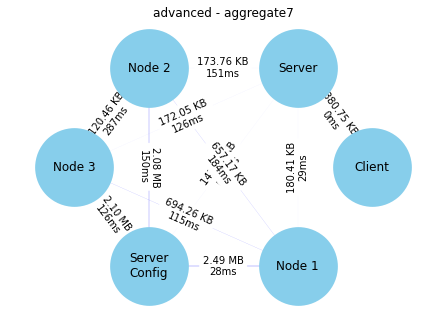

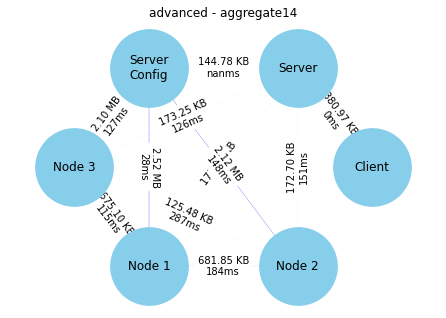

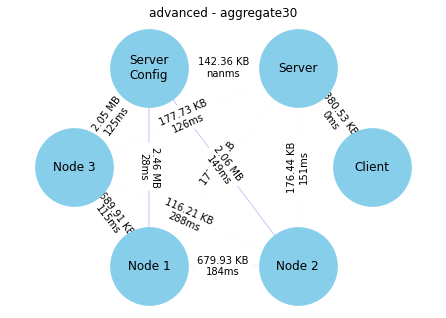

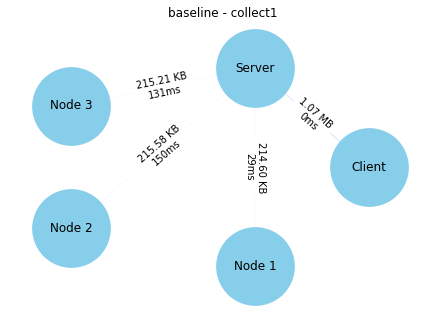

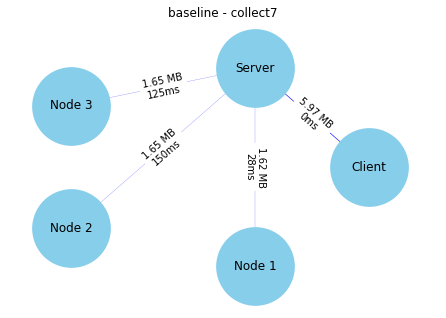

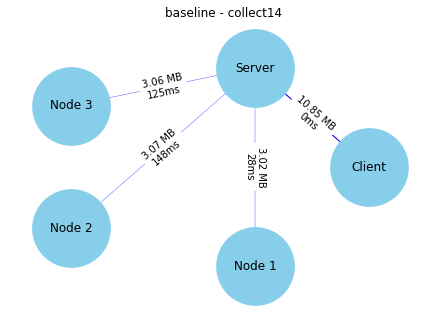

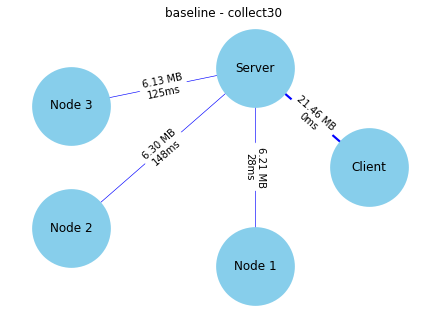

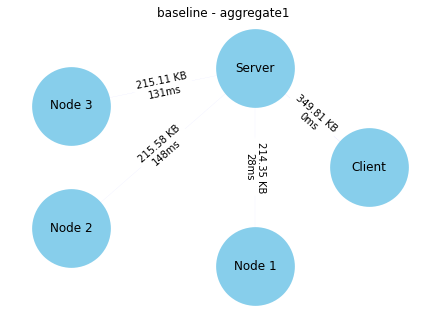

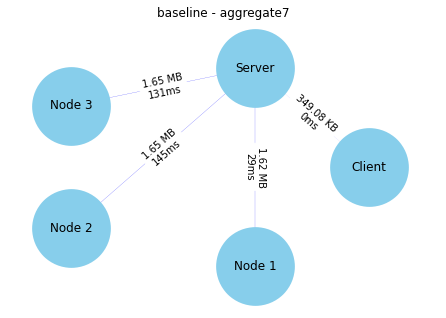

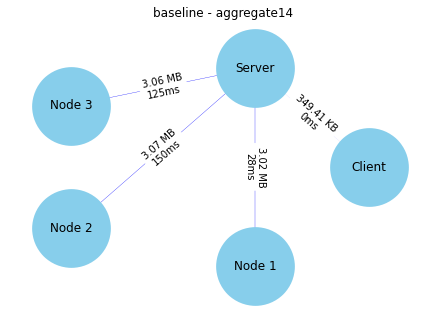

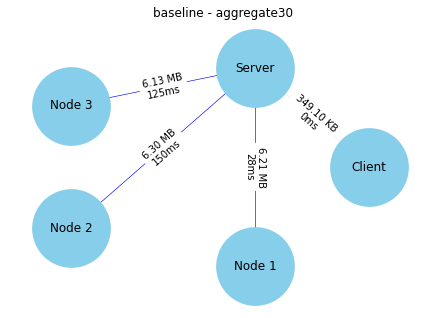

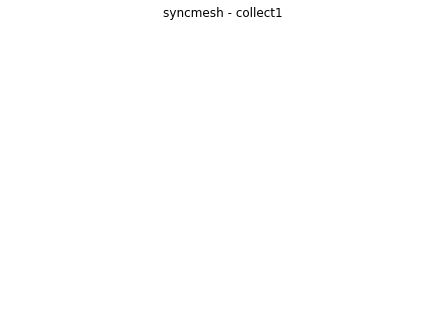

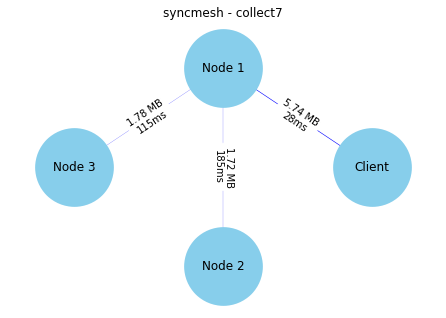

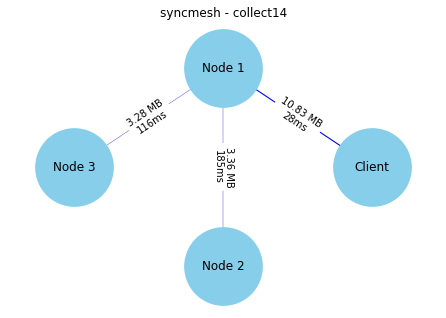

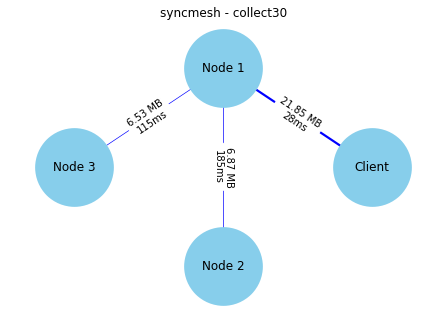

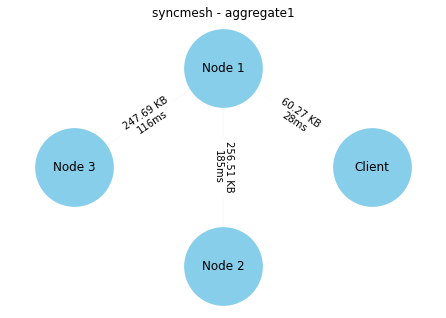

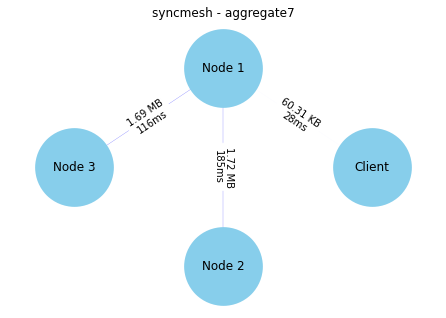

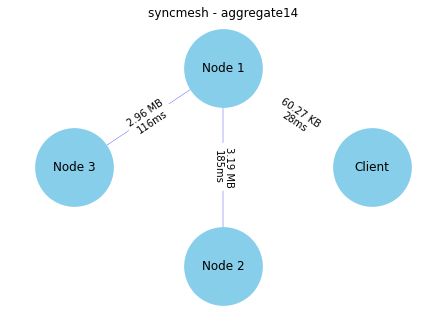

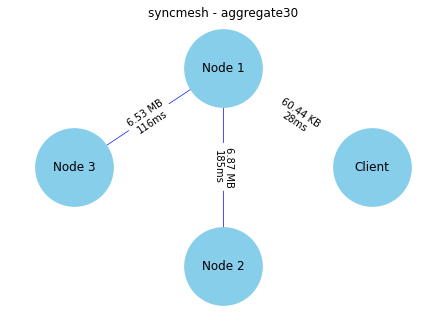

In [11]:
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        print(experiment_key)
        G = nx.Graph()
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            if len(subset["ip.dst"]) > 0:
                print(node_dataset_key) 
                G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='b', weight=subset["ip.len"].sum()/10000000, label=to_human_readable(subset["ip.len"].sum()) + "\n" + "{:.0f}".format(subset["tcp.analysis.initial_rtt"].mean(skipna=True)* 1000) + "ms")
                # print(subset["tcp.analysis.initial_rtt"].mean()* 1000)

        pos = nx.circular_layout(G)

        plt.figure(int(str(index)+str(e_index)))
        edges = G.edges()
        colors = [G[u][v]['color'] for u,v in edges]
        weights = [G[u][v]['weight'] for u,v in edges]
        edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
        nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="skyblue", node_shape="o", alpha=1, linewidths=40)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

        plt.axis('off')
        axis = plt.gca()
        axis.set_title(subset_key + " - " + experiment_key)
        axis.set_xlim([1.2*x for x in axis.get_xlim()])
        axis.set_ylim([1.2*y for y in axis.get_ylim()])
        plt.savefig("out/network_"+subset_key+"-"+experiment_key+".png")

# node_experiment_datasets
# plt.show()

In [12]:
from string import digits

s = 'abc123def456ghi789zero0'
remove_digits = str.maketrans('', '', digits)


subset_col = []
experiment_group_col = []
experiment_col = []
traffic_col = []
rtt_col = []
print("Aggregated Traffic")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        subset_col.append(subset_key)   
        experiment_group_col.append(experiment_key.translate(remove_digits))
        experiment_col.append(experiment_key)
        sum_bytes = 0
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            sum_bytes = sum_bytes + subset["ip.len"].sum()

        traffic_col.append(sum_bytes)
        print(subset_key + " - " + experiment_key + ": " + to_human_readable(sum_bytes))

print("Median RTT")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        rtt = np.array([])
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            rtt = np.append(rtt, subset["tcp.analysis.initial_rtt"].mean())

        # print(rtt)
        rtt_col.append(np.nanmean(rtt) * 1000)
        print(subset_key + " - " + experiment_key + ": " + str(np.nanmean(rtt) * 1000) + " msec " + str(statistics.median(rtt)))

Aggregated Traffic
advanced - collect1: 13.64 MB
advanced - collect7: 44.03 MB
advanced - collect14: 74.52 MB
advanced - collect30: 142.32 MB
advanced - aggregate1: 9.24 MB
advanced - aggregate7: 9.19 MB
advanced - aggregate14: 9.27 MB
advanced - aggregate30: 9.11 MB
baseline - collect1: 1.71 MB
baseline - collect7: 10.88 MB
baseline - collect14: 20.00 MB
baseline - collect30: 40.10 MB
baseline - aggregate1: 994.85 KB
baseline - aggregate7: 5.26 MB
baseline - aggregate14: 9.50 MB
baseline - aggregate30: 18.99 MB
syncmesh - collect1: 0.00 B
syncmesh - collect7: 9.24 MB
syncmesh - collect14: 17.47 MB
syncmesh - collect30: 35.26 MB
syncmesh - aggregate1: 564.47 KB
syncmesh - aggregate7: 3.47 MB
syncmesh - aggregate14: 6.21 MB
syncmesh - aggregate30: 13.46 MB
Median RTT
advanced - collect1: 120.2565624270449 msec 0.02917599999999999
advanced - collect7: 120.0416659032195 msec 0.12607599999999997
advanced - collect14: 119.39776816276833 msec 0.1260893731940818
advanced - collect30: 119.1839

/tmp/ipykernel_5684/3530630919.py:37: RuntimeWarning: Mean of empty slice
  rtt_col.append(np.nanmean(rtt) * 1000)
/tmp/ipykernel_5684/3530630919.py:38: RuntimeWarning: Mean of empty slice
  print(subset_key + " - " + experiment_key + ": " + str(np.nanmean(rtt) * 1000) + " msec " + str(statistics.median(rtt)))


StatisticsError: no median for empty data

In [40]:
analyze_table = pd.DataFrame(dict(experiment=subset_col,
scenario=experiment_group_col,
                  scenario_nodes=experiment_col,
                  traffic=traffic_col,
                  rtt=rtt_col))



sum_table = analyze_table.groupby(["experiment", "scenario"]).agg(
    traffic=("traffic", "sum"), rtt_mean=("rtt", "mean"))


sum_table.to_latex('sum_table.tex',)
def our_sort(index):
    print(index)
    # if index.name == "subset":
    print(index)
    return index 



# sum_table["rtt_mean"] = sum_table["rtt_mean"].apply(lambda x: "{:.0f} ({:+.2%})".format(x,(1-sum_table["rtt_mean"][2] / x )))
# sum_table["traffic"] = sum_table["traffic"].apply(lambda x: to_human_readable(x, False) + " ({:+.2%})".format(1-(sum_table["traffic"][2] / x )))
sum_table = sum_table.unstack(level=-1).reindex(['baseline', 'advanced', 'syncmesh'])

extra_table = sum_table.copy()
extra_table.columns = ['.'.join(col).strip() for col in sum_table.columns.values]

for scenario in ["aggregate", "collect"]:
    extra_table["rtt_mean." + scenario] = extra_table["rtt_mean." + scenario].apply(lambda x: "{:.0f} ({:+.1%})".format(x,(1-extra_table["rtt_mean." + scenario][0] / x )))
    extra_table["traffic." + scenario] = extra_table["traffic." + scenario].apply(lambda x: to_human_readable(x, False) + " ({:+.1%})".format(1-(extra_table["traffic." + scenario][0] / x )))
extra_extra_table = extra_table.columns.str.split('.', expand=True)

extra_table.columns = extra_extra_table

extra_table.rename(columns={"traffic": "Traffic (in MB)", "rtt_mean": "RTT (in ms)"}, inplace=True)
extra_table.to_latex("sum_table.tex")
extra_table
# print([tuple(col.split("%")) for col in sum_table.columns.values])


ValueError: All arrays must be of the same length

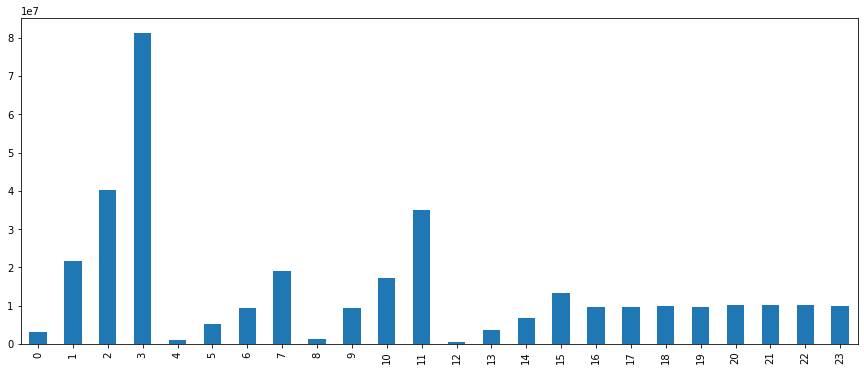

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

analyze_table['traffic'].plot.bar()

plt.show()
# This shows that the traffic is rising evenly accross multiple timeframes.

/tmp/ipykernel_5684/3467378951.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


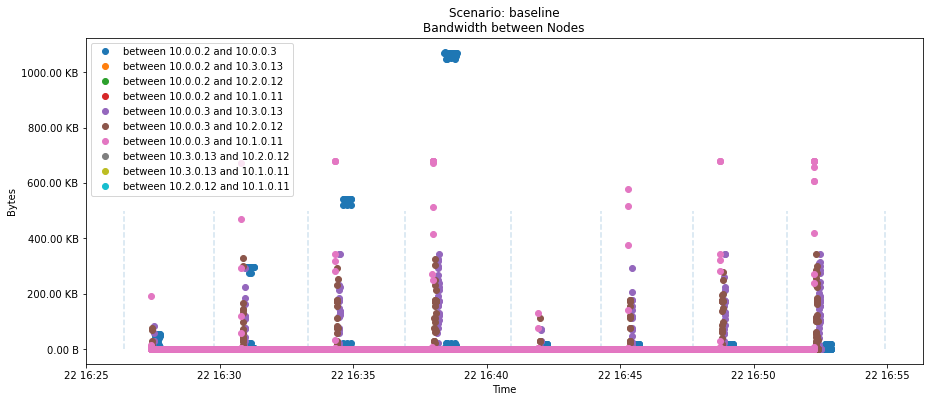

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="baseline"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

/tmp/ipykernel_5684/4238307838.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


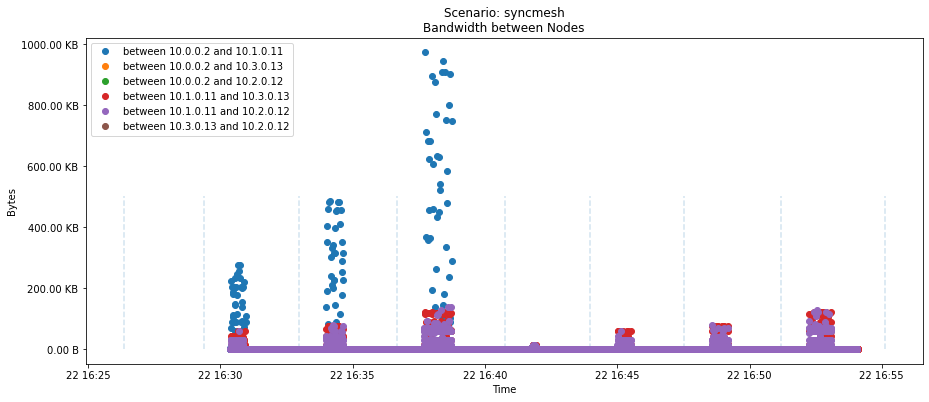

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="syncmesh"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

C:\Users\danie\AppData\Local\Temp/ipykernel_25008/1540596556.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


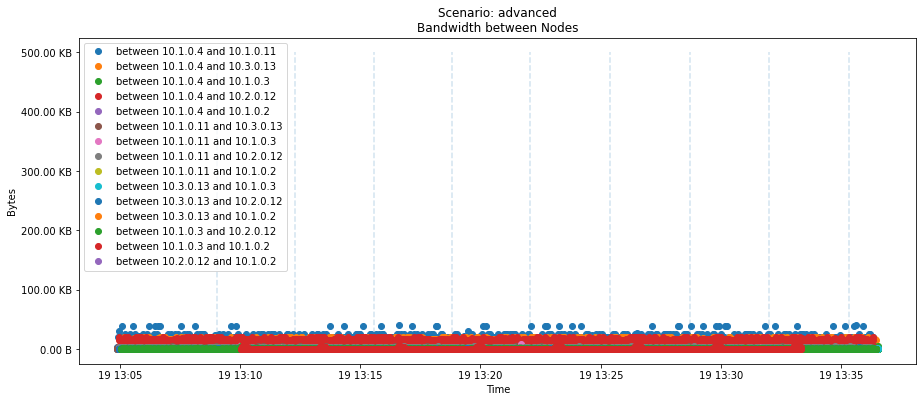

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="advanced"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

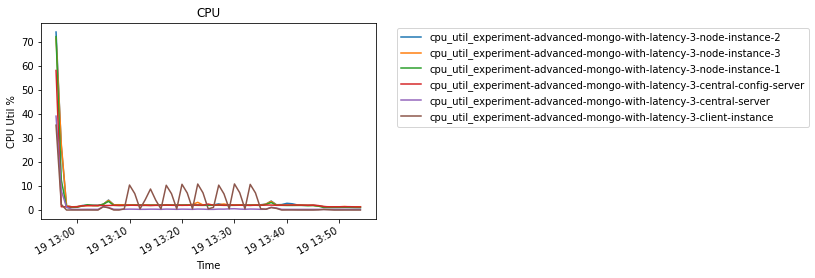

,cpu_util_experiment-advanced-mongo-with-latency-3-node-instance-2,io_read_experiment-advanced-mongo-with-latency-3-node-instance-2,io_write_experiment-advanced-mongo-with-latency-3-node-instance-2,iops_read_experiment-advanced-mongo-with-latency-3-node-instance-2,iops_write_experiment-advanced-mongo-with-latency-3-node-instance-2,cpu_util_experiment-advanced-mongo-with-latency-3-node-instance-3,io_read_experiment-advanced-mongo-with-latency-3-node-instance-3,io_write_experiment-advanced-mongo-with-latency-3-node-instance-3,iops_read_experiment-advanced-mongo-with-latency-3-node-instance-3,iops_write_experiment-advanced-mongo-with-latency-3-node-instance-3,...,cpu_util_experiment-advanced-mongo-with-latency-3-central-server,io_read_experiment-advanced-mongo-with-latency-3-central-server,io_write_experiment-advanced-mongo-with-latency-3-central-server,iops_read_experiment-advanced-mongo-with-latency-3-central-server,iops_write_experiment-advanced-mongo-with-latency-3-central-server,cpu_util_experiment-advanced-mongo-with-latency-3-client-instance,io_read_experiment-advanced-mongo-with-latency-3-client-instance,io_write_experiment-advanced-mongo-with-latency-3-client-instance,iops_read_experiment-advanced-mongo-with-latency-3-client-instance,iops_write_experiment-advanced-mongo-with-latency-3-client-instance
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-19 13:54:00,0.014244,0,1027583,0,63,0.014959,0,1004529,0,66,...,0.003945,0,361815,0,26,0.001182,0,0,0,0
2021-09-19 13:53:00,0.014378,0,1175885,0,84,0.014035,0,1168409,0,83,...,0.003882,0,412516,0,34,0.001178,0,4036,0,1
2021-09-19 13:52:00,0.014445,0,1150285,0,76,0.014184,0,1111019,0,72,...,0.003940,0,373642,0,28,0.001233,0,16203,0,3
2021-09-19 13:51:00,0.014730,24217,1097010,1,70,0.015763,0,1090184,0,70,...,0.004044,0,360721,0,26,0.001219,0,241,0,0
2021-09-19 13:50:00,0.014533,8551,1044125,0,64,0.014784,0,1050608,0,69,...,0.003969,0,368457,0,34,0.001154,0,0,0,0
2021-09-19 13:49:00,0.014505,0,1052305,0,71,0.014788,0,1104042,0,77,...,0.003947,0,420709,0,29,0.001153,0,0,0,0
2021-09-19 13:48:00,0.014397,0,1069958,0,66,0.014195,0,1077952,0,73,...,0.003923,0,353801,0,28,0.002288,0,108963,0,21
2021-09-19 13:47:00,0.015396,0,1539314,0,104,0.015394,0,1402929,0,94,...,0.004010,0,424346,0,34,0.003364,363212,368877,35,48
2021-09-19 13:46:00,0.018643,0,1697896,0,118,0.018105,0,1717588,0,120,...,0.003881,0,357899,0,23,0.001813,5428,25667,1,5


In [ ]:
df = pd.read_csv("data/20210919-15/monitoring_experiment-advanced-mongo-with-latency-3.csv")
columns = df.columns
df.set_index('timestamp', inplace=True)
# df = df.loc[str(pd.to_datetime("2021-09-15T09:10:00")):str(pd.to_datetime("2021-09-15T08:37:00"))]
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("cpu_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('CPU')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()
df